In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(ComplexHeatmap)
library(grid)
library(circlize)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort.

In [2]:
#pre-processed region × celltypes seurat object, detail see this study Method, download from https://db.cngb.org/stomics/mbcsta/download/
obj_segment <- readRDS('data/Segment_celltypes_marmoset.rds')

In [3]:
#The processed segment × genes files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
obj_segment_gene <- readRDS('data/Segment_genes_marmoset.rds')

In [4]:
#The processed segment × genes ROC files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/
obj_segment_gene_ROC <- readRDS('data/Segment_genes_ROC_marmoset.rds')
obj_segment_gene_ROC_section <- readRDS('data/Segment_genes_ROC_section_marmoset.rds')

In [38]:
source('R_function/ST_plot.R')
source('R_function/knn_function.R')
source('R_function/segment_plot.R')
source('R_function/ROC_plot.R')
source('R_function/calculate_function.R')

In [6]:
#The segment border files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/ or https://github.com/haoshijie13/MCCSTA
Border <- read.csv('data/Border.txt')

<font size=10>---------------Calculate cell types ROC-------------<font size=10>

In [9]:
ROC_matrix <- rbind(as.matrix(obj_segment@assays$Neuron_smooth@data),as.matrix(obj_segment@assays$NN_smooth@data))
source('R_function/knn_function.R')
#Set progress bar
all_n <- length(rownames(ROC_matrix))
n <- 1
pb <- txtProgressBar(style=3)
for( i in rownames(ROC_matrix)){
    #Calculate cell type ROC by using ROC_kNN from knn_function
    ROC_matrix[i,] <- ROC_kNN(obj_segment@meta.data[,c('X_axis','Y_axis_smooth')],
                        ROC_matrix[i,],
                        knn=16)
    #Set progress bar
    setTxtProgressBar(pb, n/all_n)
    n <- n+1
}
close(pb)
ROC_matrix <- CreateAssayObject(data=ROC_matrix)
obj_segment[['ROC']] <- ROC_matrix

#Expand X_axis to avoid sections interact with each other
obj_segment$X_axis_expand <- obj_segment$X_axis*1e5
ROC_matrix <- rbind(as.matrix(obj_segment@assays$Neuron@data),as.matrix(obj_segment@assays$NN@data))
#Set progress bar
all_n <- length(rownames(ROC_matrix))
n <- 1
pb <- txtProgressBar(style=3)
for( i in rownames(ROC_matrix)){
    #Smooth cell distribution in each section 
    tmp <- smooth_kNN(
        obj_segment@meta.data[,c('X_axis_expand','Y_axis_smooth')],
        obj_segment@meta.data[,c('X_axis_expand','Y_axis_smooth')],
        ROC_matrix[i,],
        knn=9,round=4)
    #Calculate cell type ROC by using ROC_kNN from knn_function
    ROC_matrix[i,] <- ROC_kNN(obj_segment@meta.data[,c('X_axis_expand','Y_axis_smooth')],
                               tmp,
                               knn=9)
    #Set progress bar
    setTxtProgressBar(pb, n/all_n)
    n <- n+1
}
close(pb)
ROC_matrix <- CreateAssayObject(data=ROC_matrix)
obj_segment[['ROC_section']] <- ROC_matrix

  |======================================================================| 100%
  |======================================================================| 100%


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from roc_section_ to rocsection_”


<font size=10>---------------Calculate genes ROC-------------<font size=10>

In [ ]:
obj_segment_gene_ROC <- obj_segment_gene
ROC_matrix <- as.matrix(obj_segment_gene_ROC@assays$RNA@data)
#Set progress bar
all_n <- length(rownames(ROC_matrix))
n <- 1
pb <- txtProgressBar(style=3)
for( i in rownames(ROC_matrix)){
    #Calculate gene ROC by using ROC_kNN from knn_function
    ROC_matrix[i,] <- ROC_kNN(obj_segment_gene_ROC@meta.data[,c('X_axis','Y_axis_smooth')],
                       tmp,
                       knn=16)
    #Set progress bar
    setTxtProgressBar(pb, n/all_n)
    n <- n+1}
close(pb)

ROC_matrix <- CreateAssayObject(data=ROC_matrix)
obj_segment_gene_ROC[['ROC']] <- ROC_matrix
obj_segment_gene_ROC@active.assay <- 'ROC'
obj_segment_gene_ROC[['RNA']] <- NULL

In [39]:
obj_segment_gene_ROC_section <- CreateSeuratObject(obj_segment_gene@assays$RNA@counts,meta.data = obj_segment_gene@meta.data)
obj_segment_gene_ROC_section <- NormalizeData(obj_segment_gene_ROC_section)
ROC_matrix <- as.matrix(obj_segment_gene_ROC_section@assays$RNA@data)
#Expand X_axis to avoid sections interact with each other
obj_segment_gene_ROC_section$X_axis_expand <- obj_segment_gene_ROC_section$X_axis*1e5
#Set progress bar
all_n <- length(rownames(ROC_matrix))
n <- 1
pb <- txtProgressBar(style=3)
for( i in rownames(ROC_matrix)){
    #Smooth cell distribution in each section 
    tmp <- smooth_kNN(
        obj_segment_gene_ROC_section@meta.data[,c('X_axis_expand','Y_axis_smooth')],
        obj_segment_gene_ROC_section@meta.data[,c('X_axis_expand','Y_axis_smooth')],
        ROC_matrix[i,],
        knn=9,round=4)
    #Calculate cell type ROC by using ROC_kNN from knn_function
    ROC_matrix[i,] <- ROC_kNN(obj_segment_gene_ROC_section@meta.data[,c('X_axis_expand','Y_axis_smooth')],
                               tmp,
                               knn=9)
    #Set progress bar
    setTxtProgressBar(pb, n/all_n)
    n <- n+1
}
close(pb)
ROC_matrix <- CreateAssayObject(data=ROC_matrix)
obj_segment_gene_ROC_section[['ROC_section']] <- ROC_matrix
obj_segment_gene_ROC_section@active.assay <- 'ROC_section'
obj_segment_gene_ROC_section[['RNA']] <- NULL

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.5 GiB”


  |======================================================================| 100%


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from roc_section_ to rocsection_”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


<font size=10>---------------Plot ROC-------------<font size=10>

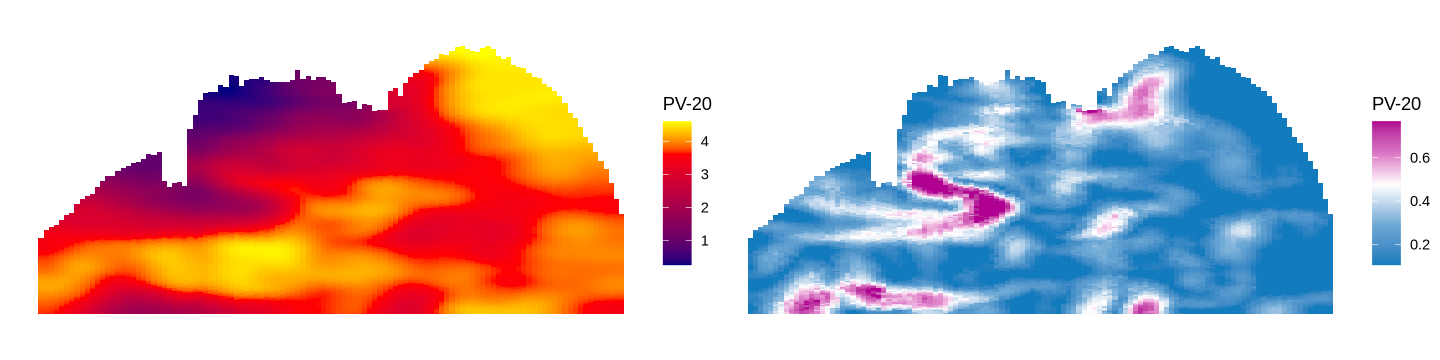

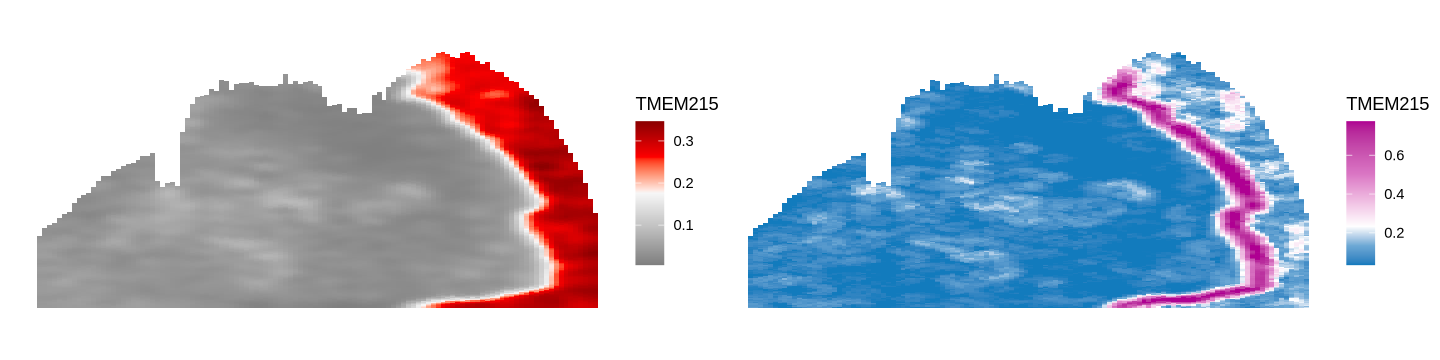

In [55]:
source('R_function/segment_plot.R')
#Plot cell type or gene ROC by using plot_features from segment_plot.R
options(repr.plot.width=12,repr.plot.height=3)
p1 <- plot_features(obj_segment,features = 'PV-20',vmid=0.5,border=F,assays='Neuron_smooth',slot='data')
p2 <- plot_features(obj_segment,features = 'PV-20',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','#6DA9D5','white','#DA76C4','#AF0092'))
p1+p2
p1 <- plot_features(obj_segment_gene,features = 'TMEM215',border=F,assays='RNA',slot='data',color = c('gray50','gray','gray97','red','darkred'))
p2 <- plot_features(obj_segment_gene_ROC,features = 'TMEM215',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','#6DA9D5','white','#DA76C4','#AF0092'))
p1+p2

In [65]:
options(repr.plot.width=12,repr.plot.height=3)
p1 <- plot_features(obj_segment,features = 'PV-20',vmid=0.5,border=F,assays='Neuron_smooth',slot='data')
p2 <- plot_features(obj_segment,features = 'PV-20',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','white','#AF0092'))
save_png_plot(p1,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'PV-20')
save_png_plot(p2,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'PV-20.ROC')

p1 <- plot_features(obj_segment,features = 'L4-2',vmid=0.5,border=F,assays='Neuron_smooth',slot='data')
p2 <- plot_features(obj_segment,features = 'L4-2',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','white','#AF0092'))
save_png_plot(p1,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'L4-2')
save_png_plot(p2,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'L4-2.ROC')

p1 <- plot_features(obj_segment,features = 'L5/6-21',vmid=0.5,border=F,assays='Neuron_smooth',slot='data')
p2 <- plot_features(obj_segment,features = 'L5/6-21',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','white','#AF0092'))
save_png_plot(p1,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'L5_6-21')
save_png_plot(p2,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample/',name = 'L5_6-21.ROC')

p1 <- plot_features(obj_segment_gene,features = 'TMEM215',border=F,assays='RNA',slot='data',color = c('gray50','gray','gray97','red','darkred'))
p2 <- plot_features(obj_segment_gene_ROC,features = 'TMEM215',min.cutoff=0.2,vmid=0.9,max.cutoff = 0.99,border=F,assays='ROC',slot='data',color = c('#127BBD','white','#AF0092'))
save_png_plot(p1,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample_gene/',name = 'TMEM215')
save_png_plot(p2,dir_path = '~/Marmoset_Brain/Summary/plot/Border/Sample_gene/',name = 'TMEM215.ROC')

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

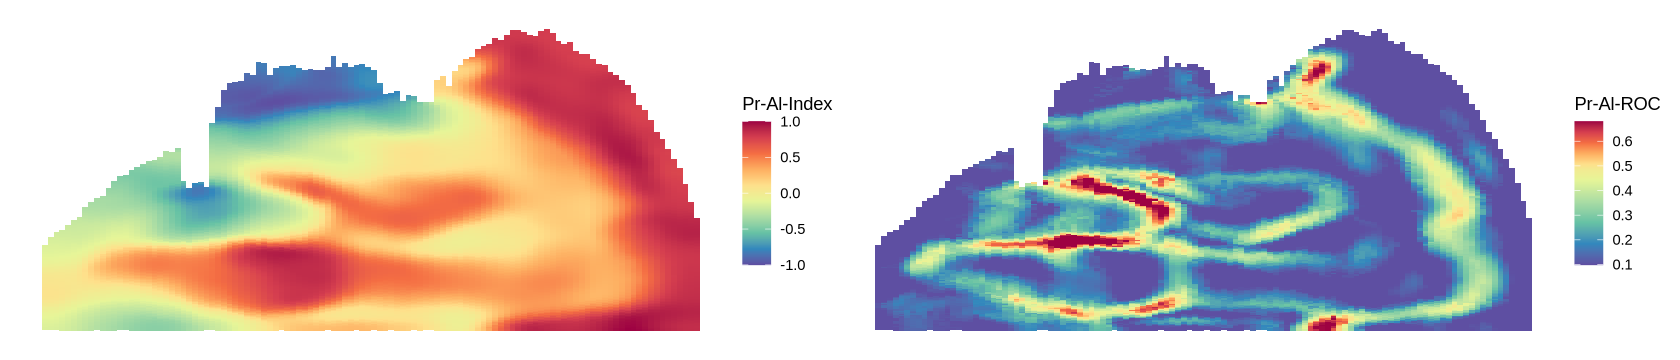

In [10]:
#Calculate Pr-Al Index ROC by using ROC_kNN from knn_function
obj_segment$`Pr-Al-ROC` <- ROC_kNN(obj_segment@meta.data[,c('X_axis','Y_axis_smooth')],
                               obj_segment$`Pr-Al-Index`,
                               knn=16)
options(repr.plot.width=14,repr.plot.height=3)
p1 <- plot_col_exp(obj_segment@meta.data,'Pr-Al-Index',border = F)
p2 <- plot_col_exp(obj_segment@meta.data,'Pr-Al-ROC',border = F,vmid=0.95,min.cutoff=0.3,max.cutoff = 0.99)
p1+p2

In [20]:
#The segment ROC border files can be downloaded at https://db.cngb.org/stomics/mbcsta/download/ or https://github.com/haoshijie13/MCCSTA
ROC_manual_Border <- read.csv('data/ROC_manual_Border.txt')

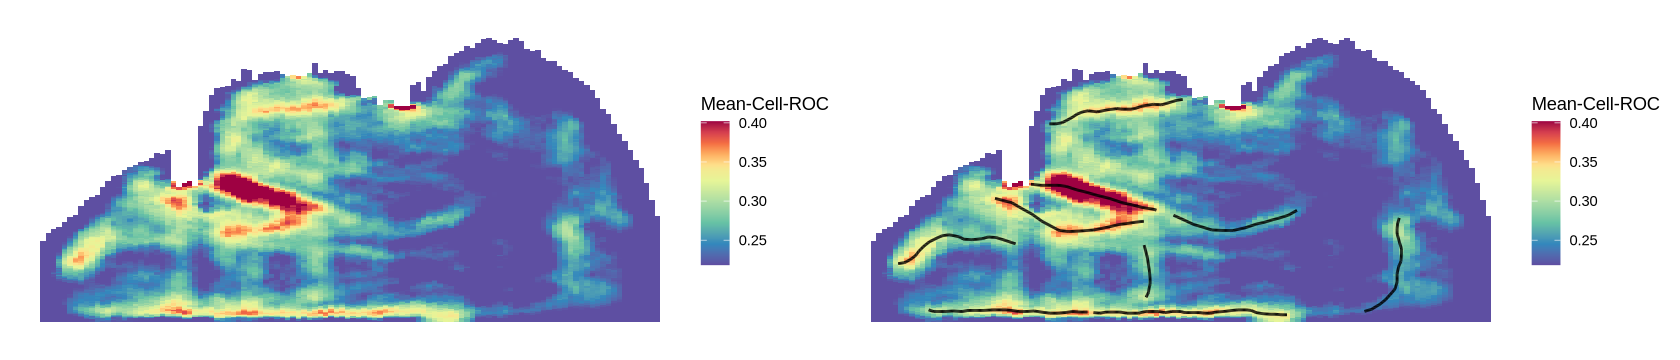

In [25]:
#Calculate Mean ROC of all cell types
obj_segment$`Mean-Cell-ROC` <- colMeans(obj_segment[['ROC']]$data)
options(repr.plot.width=14,repr.plot.height=3)
p1 <- plot_col_exp(obj_segment@meta.data,'Mean-Cell-ROC',border = F,vmid=0.95,min.cutoff=0.3,max.cutoff = 0.99)
p2 <- plot_col_exp(obj_segment@meta.data,'Mean-Cell-ROC',border = T,border_use = ROC_manual_Border,vmid=0.95,min.cutoff=0.3,max.cutoff = 0.99)
p1+p2

In [18]:
slice_gene_sample <- readRDS('/mnt/SSD16Ta/huangzhi/cortex_gem/T450.rds')
slice_gene_sample <- NormalizeData(slice_gene_sample)
slice_gene_sample$sample <- slice_gene_sample$orig.ident
slice_gene_sample$x <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][2])}))
slice_gene_sample$y <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][3])}))

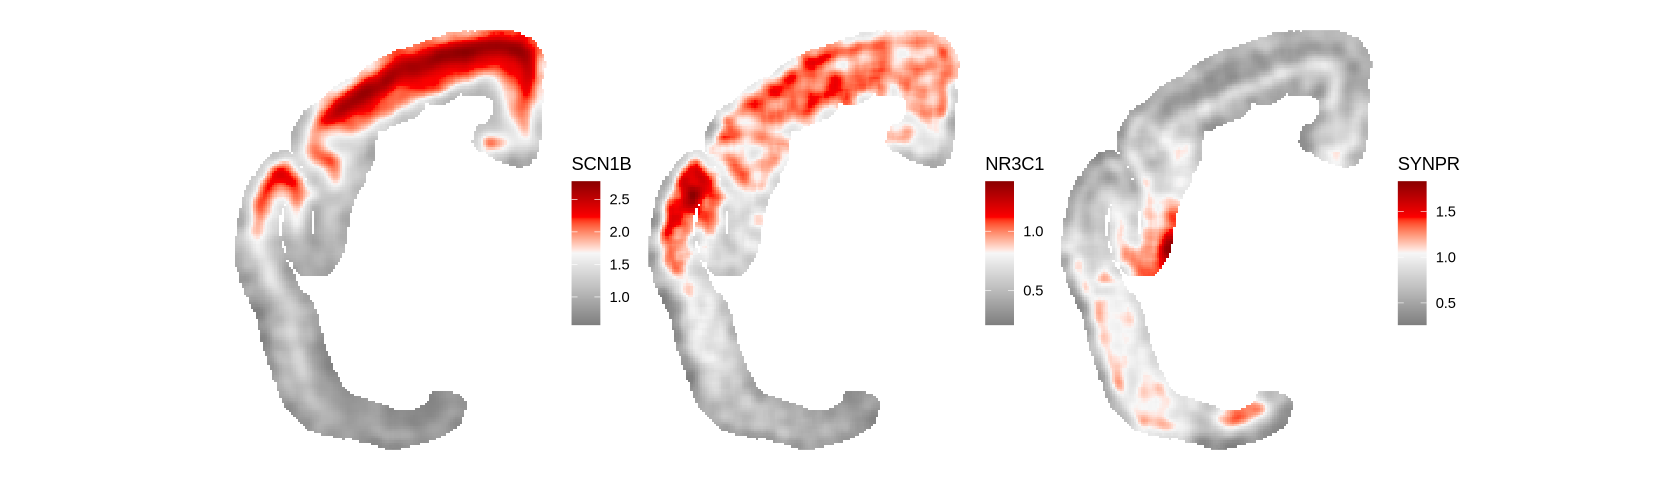

In [100]:
options(repr.plot.width=14,repr.plot.height=4)
#Plot S2-Insular shape change gene by using plot_spatial_feature from ST_plot.R
source('R_function/ST_plot.R')
plot_spatial_feature(slice_gene_sample,'SCN1B')+plot_spatial_feature(slice_gene_sample,'NR3C1')+plot_spatial_feature(slice_gene_sample,'SYNPR')

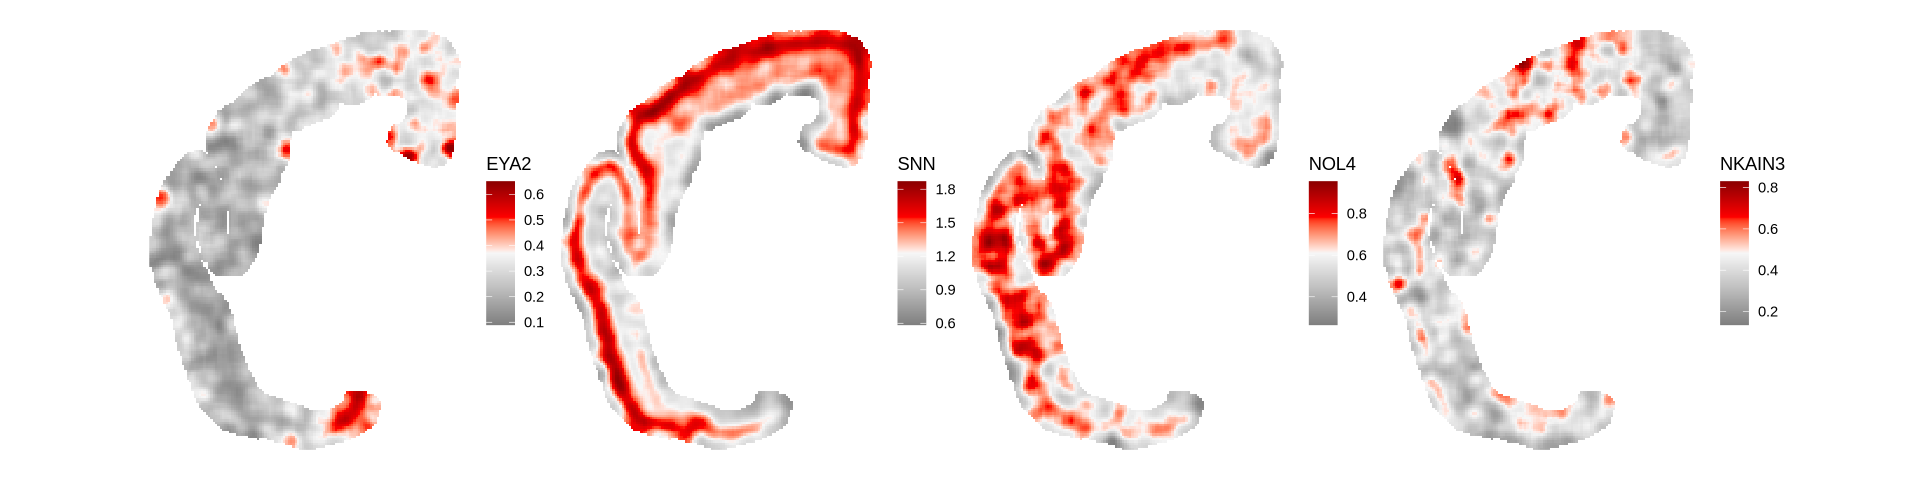

In [106]:
options(repr.plot.width=16,repr.plot.height=4)
#Plot Ent and A4ab shape change gene by using plot_spatial_feature from ST_plot.R
plot_spatial_feature(slice_gene_sample,'EYA2')+plot_spatial_feature(slice_gene_sample,'SNN')+
plot_spatial_feature(slice_gene_sample,'NOL4')+plot_spatial_feature(slice_gene_sample,'NKAIN3')+plot_layout(ncol=4)

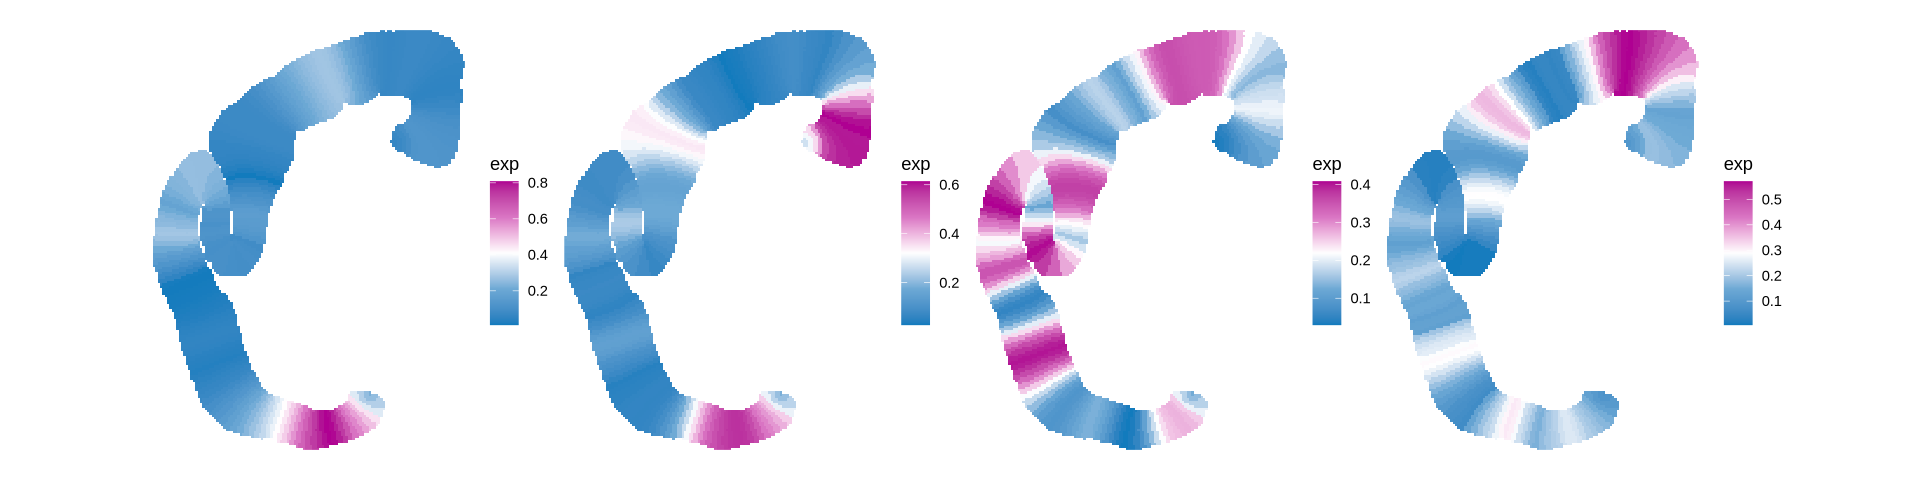

In [57]:
options(repr.plot.width=16,repr.plot.height=4)
source('R_function/ROC_plot.R')
#Plot Ent and A4ab shape change gene ROC by using plot_spatial_ROC from ST_plot.R
plot_spatial_ROC(slice_gene_sample,'EYA2')+plot_spatial_ROC(slice_gene_sample,'SNN')+
plot_spatial_ROC(slice_gene_sample,'NOL4')+plot_spatial_ROC(slice_gene_sample,'NKAIN3')+plot_layout(ncol=4)

In [50]:
for(i in c('SCN1B','NR3C1','SYNPR','MARCKS','TESPA1','RIMS3','FOXP1','PDXK','EYA2','SNN','NOL4','NKAIN3',
           'PID1','VAMP1','SCRT1','ROBO2','KCNS1','AGL','ALCAM','CAMK1','CYP26B1')){
save_png_plot(plot_spatial_feature(slice_gene_sample,i),dir_path = '~/Marmoset_Brain/Summary/plot/Border/gene_spatial_plot_middle/',name = paste0(i,'_T450'),width=1400, height=1900)
           }
for(i in c('EYA2','SNN','NOL4','NKAIN3')){
save_png_plot(plot_spatial_ROC(slice_gene_sample,i),dir_path = '~/Marmoset_Brain/Summary/plot/Border/gene_spatial_plot_middle/',
              name = paste0(i,'_T450_gradient'),width=1400, height=1400)
           }

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


In [50]:
slice_gene_sample <- readRDS('/mnt/SSD16Ta/huangzhi/cortex_gem/T475.rds')
slice_gene_sample <- NormalizeData(slice_gene_sample)
slice_gene_sample$sample <- slice_gene_sample$orig.ident
slice_gene_sample$x <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][2])}))
slice_gene_sample$y <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][3])}))

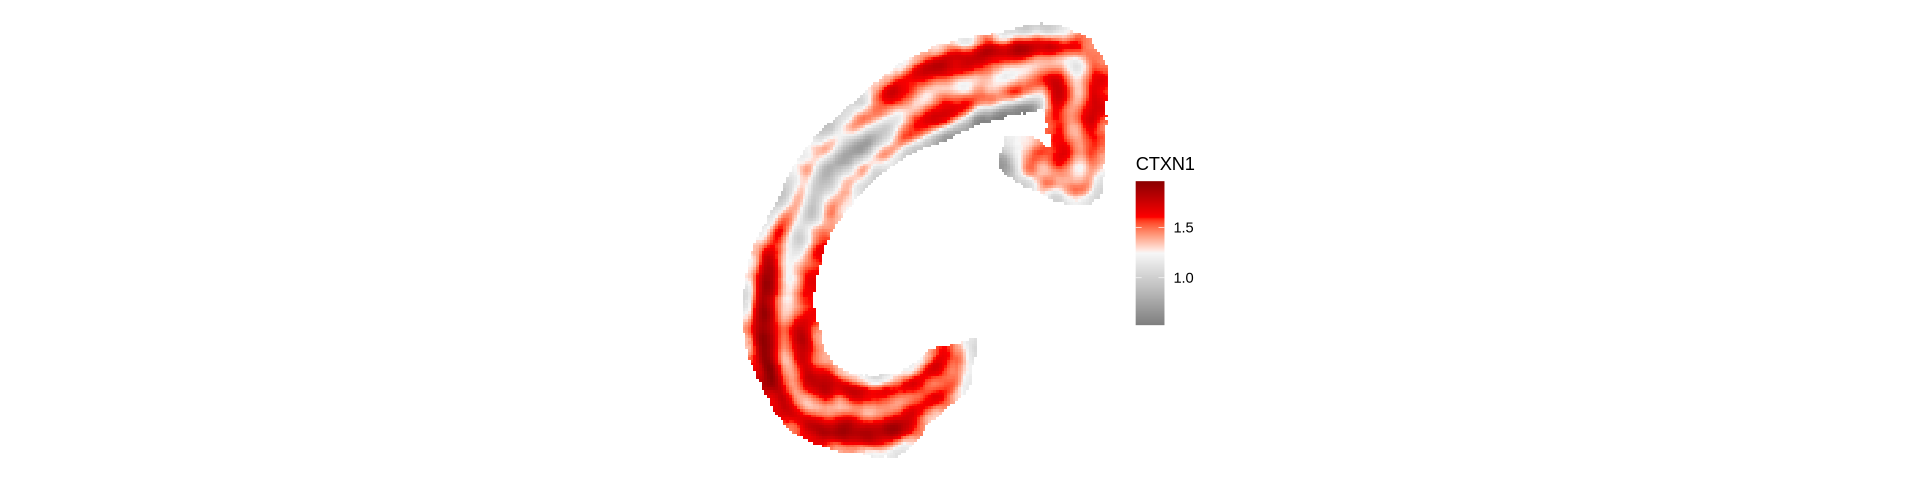

In [52]:
options(repr.plot.width=16,repr.plot.height=4)
#Plot PG-MST/V5 shape change gene by using plot_spatial_feature from ST_plot.R
plot_spatial_feature(slice_gene_sample,'CTXN1')

In [53]:
save_png_plot(plot_spatial_feature(slice_gene_sample,'CTXN1'),dir_path = '~/Marmoset_Brain/Summary/plot/Border/gene_spatial_plot_V5/',
              name = paste0('CTXN1','_T450_gradient'),width=1400, height=1400)

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

In [54]:
slice_gene_sample <- readRDS('/mnt/SSD16Ta/huangzhi/cortex_gem/T507.rds')
slice_gene_sample <- NormalizeData(slice_gene_sample)
slice_gene_sample$sample <- slice_gene_sample$orig.ident
slice_gene_sample$x <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][2])}))
slice_gene_sample$y <- as.numeric(sapply(colnames(slice_gene_sample),function(x){return(strsplit(x,'_')[[1]][3])}))

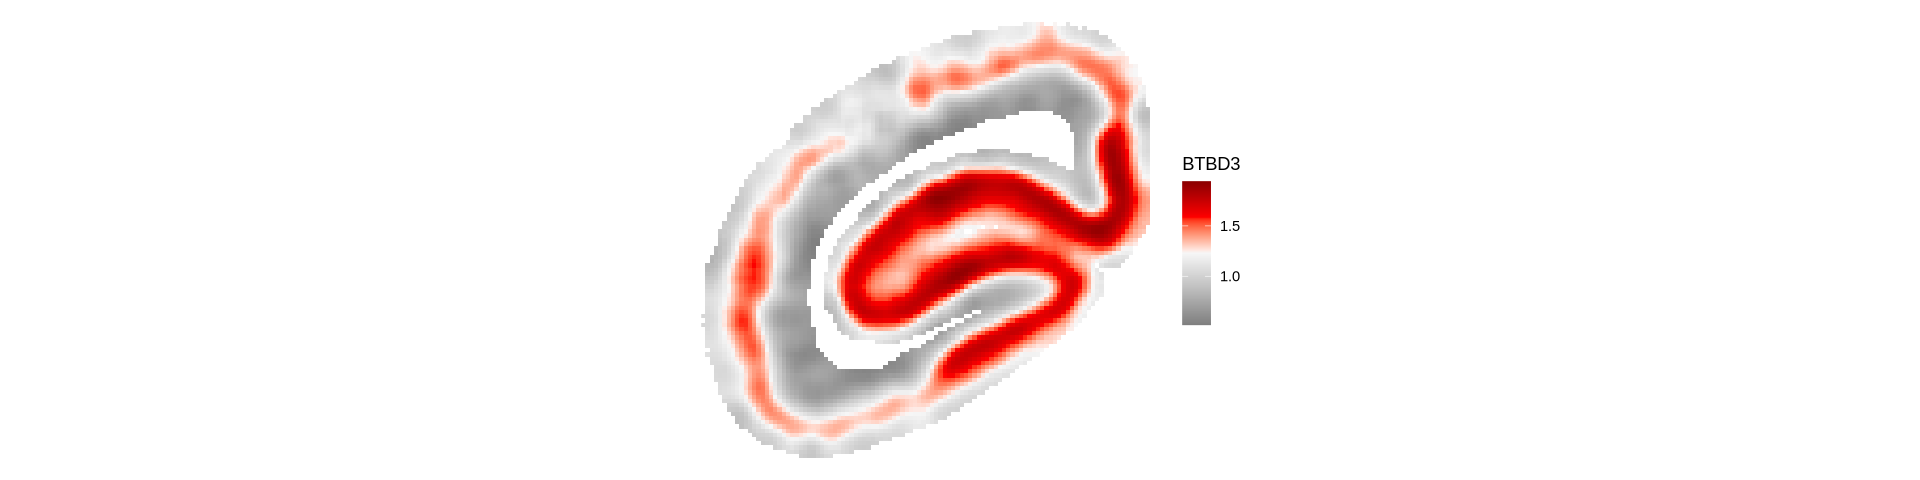

In [55]:
options(repr.plot.width=16,repr.plot.height=4)
#Plot V1-V2 shape change gene by using plot_spatial_feature from ST_plot.R
plot_spatial_feature(slice_gene_sample,'BTBD3')

In [56]:
save_png_plot(plot_spatial_feature(slice_gene_sample,'BTBD3'),dir_path = '~/Marmoset_Brain/Summary/plot/Border/gene_spatial_plot_V1/',
              name = paste0('BTBD3','_T507'),width=1400, height=1400)

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


NULL


pdf 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



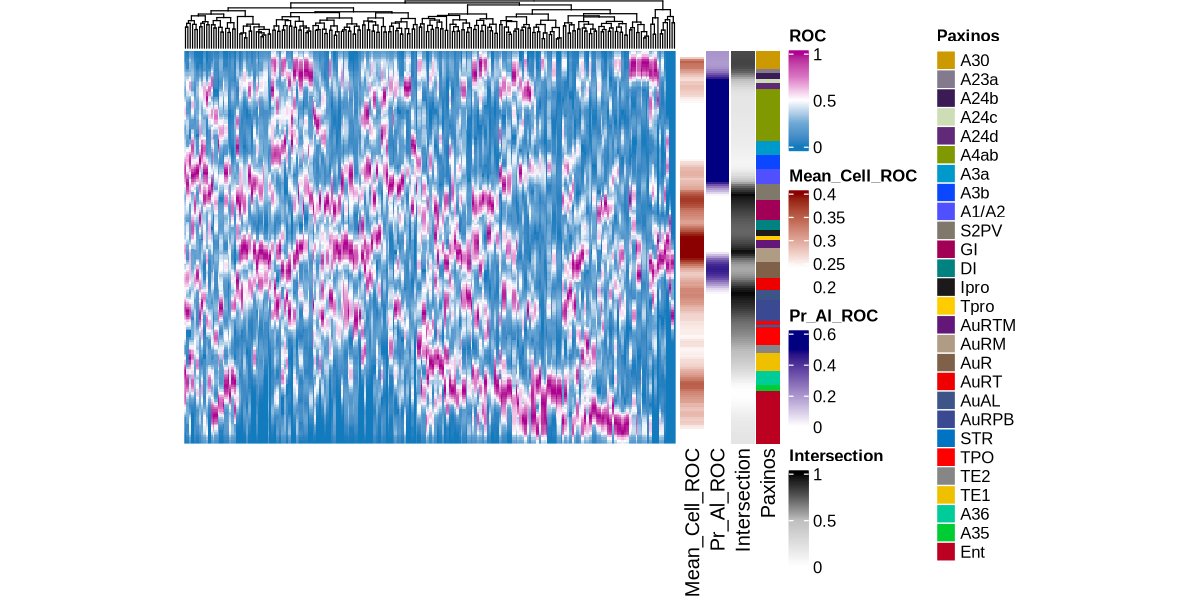

In [59]:
options(repr.plot.width=10,repr.plot.height=5)
source('R_function/ROC_plot.R')
#Plot celltype ROC matrix by using plot_celltype_heatmap_ROC from ROC_plot.R
p1 <- plot_celltype_heatmap_ROC(obj = obj_segment,slice = 'T450',MCR_range = c(0.24, 0.4))
p1

In [30]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T450_heatmap.pdf',width=10,height=5)
p1
dev.off()

pdf 
  2

In [58]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T475_heatmap.pdf',width=10,height=5)
plot_celltype_heatmap_ROC(obj = obj_segment,slice = 'T475',MCR_range = c(0.2, 0.3))
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

In [60]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T507_heatmap.pdf',width=10,height=5)
plot_celltype_heatmap_ROC(obj = obj_segment,slice = 'T507',MCR_range = c(0.2, 0.3))
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

Don't know how to automatically pick scale for object of type <table>.
Defaulting to continuous.


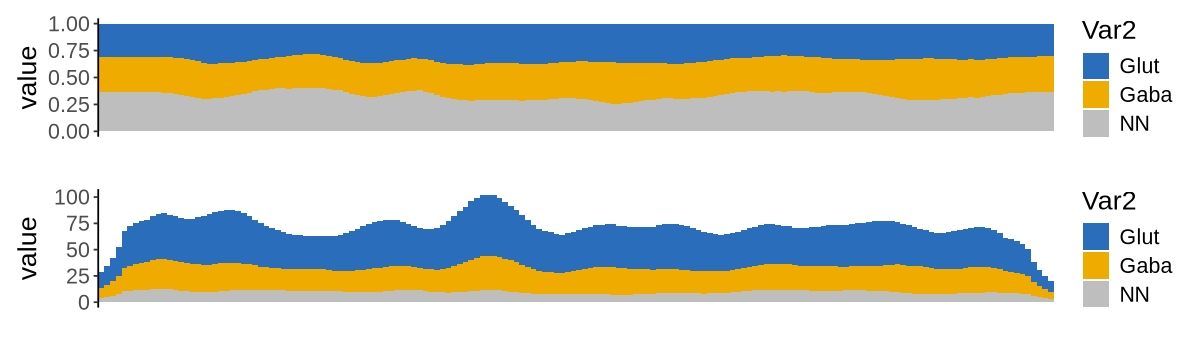

In [39]:
source('R_function/ROC_plot.R')
#Plot celltype ROC cumulative bar by using plot_celltype_percent_ROC from ROC_plot.R
p1 <- plot_celltype_percent_ROC(obj_segment,'T475',normal = T,position = 'fill')
options(repr.plot.width=10,repr.plot.height=3)
p2 <- plot_celltype_percent_ROC(obj_segment,'T475',normal = F)
options(repr.plot.width=10,repr.plot.height=3)
p1/p2

In [40]:
#Find the high expression genes
use_gene <- data.frame(gene=rownames(obj_segment_gene@assays$RNA@data),exp=rowSums(obj_segment_gene@assays$RNA@data))
use_gene <- use_gene[ order(use_gene$exp,decreasing = T),]

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



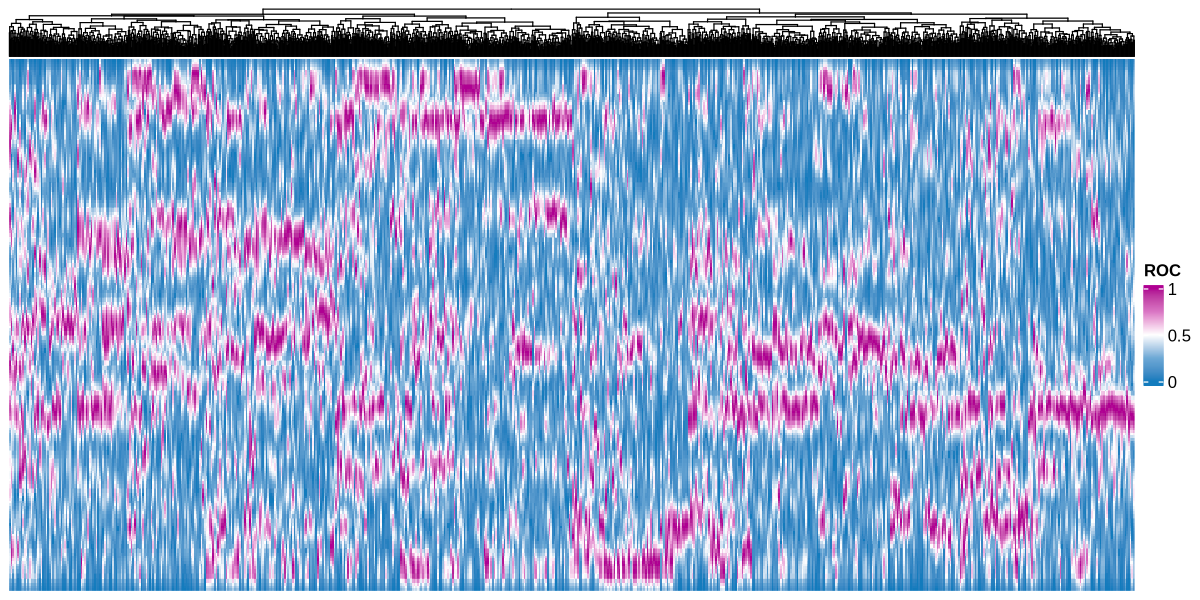

In [48]:
options(repr.plot.width=10,repr.plot.height=5)
source('R_function/ROC_plot.R')
p1 <- plot_gene_heatmap_ROC(obj_segment_gene_ROC_section,'T450',gene_list = use_gene$gene[1:2000],cluster_columns=T)
p1

In [49]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T450_heatmap_genes.pdf',width=10,height=5)
p1
dev.off()

pdf 
  2

In [61]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T475_heatmap_genes.pdf',width=10,height=5)
plot_gene_heatmap_ROC(obj_segment_gene_ROC_section,'T475',gene_list = use_gene$gene[1:2000],cluster_columns=T)
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

In [62]:
pdf('~/Marmoset_Brain/Summary/plot/Border/T507_heatmap_genes.pdf',width=10,height=5)
plot_gene_heatmap_ROC(obj_segment_gene_ROC_section,'T507',gene_list = use_gene$gene[1:2000],cluster_columns=T)
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2